In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
from clingo.control import Control
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sympy import symbols, Not, Or, And, simplify_logic
import re

np.random.seed(42)

In [2]:
def parse_literal(lit_str):
    """Parses a literal like '-p1' or 'p2' into a SymPy expression."""
    lit_str = lit_str.strip()
    if lit_str.startswith('-'):
        return Not(symbols(lit_str[1:]))
    else:
        return symbols(lit_str)

def parse_clause(clause_str):
    """Parses a clause like '-p1 | p2 | -p3' into Or(...)"""
    literals = [parse_literal(lit) for lit in clause_str.split('|')]
    return Or(*literals)

def parse_cnf(cnf_str):
    """Parses the whole CNF string like '-p1 | p2 & -p3 | p4' into And(...)"""
    clause_strs = re.split(r'\s*&\s*', cnf_str)
    clauses = [parse_clause(clause) for clause in clause_strs]
    return And(*clauses)

def sympy_literal_to_str(lit):
    if isinstance(lit, Not):
        return f"-{lit.args[0]}"
    else:
        return str(lit)

def clause_to_str(clause):
    if isinstance(clause, Or):
        return ' | '.join(sympy_literal_to_str(arg) for arg in clause.args)
    else:
        return sympy_literal_to_str(clause)

def expr_to_custom_cnf_format(expr):
    if isinstance(expr, And):
        return ' & '.join(clause_to_str(arg) for arg in expr.args)
    else:
        return clause_to_str(expr)

def simplify_cnf_formula(cnf_str):
    expr = parse_cnf(cnf_str)
    simplified = simplify_logic(expr, form='cnf')
    return expr_to_custom_cnf_format(simplified)

def tree_to_cnf(tree, feature_names, v1 = 1, v2 = 0):
    tree = tree.tree_
    fact_clauses = []
    foil_clauses = []
    var_mapping = {}
    var_counter = [1]  # Mutable counter

    def fresh_var():
        name = f'p{var_counter[0]}'
        var_counter[0] += 1
        return name
    
    def entails(l1,l2):
        if l1[1] != l2[1] or var_mapping[l1[0]][0] != var_mapping[l2[0]][0]:
            return False
        else:
            t1 = var_mapping[l1[0]][1]
            t2 = var_mapping[l2[0]][1]
            if l1[1] == 0 and t1 >= t2:
                return True
            elif l1[1] == 1 and t1 <= t2:
                return True
            else:
                return False
    
    def some_literal_entails(l, path):
        for ll in path:
            if l[0] != ll[0] and entails(ll,l):
                return True
        return False

    def traverse(node, path):
        if tree.feature[node] == _tree.TREE_UNDEFINED:
            pp_path = [l for l in path if not some_literal_entails(l, path)]
            pp_path = [l[0] for l in pp_path if l[1] == 1] + [f'-{l[0]}' for l in pp_path if l[1] == 0]

            c = tree.value[node][0].argmax()
            if c != v1:
                fact_clauses.append(pp_path)
            if c != v2:
                foil_clauses.append(pp_path)
        else:
            feature_index = tree.feature[node]
            threshold = round(tree.threshold[node], 4)
            feature = feature_names[feature_index]

            # Search for an existing variable with the same [feature, threshold]
            existing_var = None
            for var, pair in var_mapping.items():
                if pair == [feature, threshold]:
                    existing_var = var
                    break

            if existing_var is not None:
                var = existing_var  # Reuse the existing variable
            else:
                var = fresh_var()
                var_mapping[var] = [feature, threshold]

            # Left: feature <= threshold  → -var
            traverse(
                tree.children_left[node],
                path + [[var, 0]]
            )

            # Right: feature > threshold → var
            traverse(
                tree.children_right[node],
                path + [[var, 1]]
            )

    # Start traversal from root
    traverse(0, [])

    # Construct CNF formulas
    fact_cnf = simplify_cnf_formula(' & '.join([' | '.join(clause) for clause in fact_clauses]))
    foil_cnf = simplify_cnf_formula(' & '.join([' | '.join(clause) for clause in foil_clauses]))

    return {
        'fact_cnf': fact_cnf,
        'foil_cnf': foil_cnf,
        'var_mapping': var_mapping
    }

ENC = {
    "GLOBAL_CE" : "prototype/enc_def3.lp",
    "CF_CE"     : "prototype/enc_def5.lp",
    "CF_DIFF"   : "prototype/enc_def6.lp"
}

def __parse_cnf(str):
    cnf = []
    for str_cl in str.split("&"):
        cl = []
        for str_lit in str_cl.split("|"):
            s = str_lit.strip()
            if s.startswith('-'):
                cl.append((s[1:],False))
            else:
                cl.append((s,True))
        cnf.append(cl)
    
    return cnf

def __cnf_to_facts(instance_cnf,fact_cnf,foil_cnf):
    facts = []
    i = 1
    for cl in instance_cnf:
        facts.append(f"instance_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in fact_cnf:
        facts.append(f"fact_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
    for cl in foil_cnf:
        facts.append(f"foil_cl({i}).")
        for l,t in cl:
            sign = "t" if t else "f"
            facts.append(f"lit({i},{l},{sign}).")
        i += 1
        
    return facts


def __cnf_to_str(cnf):
    cl_str = []
    for cl in cnf:
        parse_lit = lambda l,s: l if s else f"-{l}" 
        cl_str.append(" | ".join([ parse_lit(l,s) for l,s in cl ]))
    
    return "  &  ".join(cl_str)


def __parse_answer_set(answer_set):
    theta = {}
    theta_p = {}
    chi = {}
    for sym in answer_set.symbols(shown=True):
        if sym.match('theta_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta:
                theta[c] = []
            theta[c].append((l,s == "t"))
        elif sym.match('theta_p_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in theta_p:
                theta_p[c] = []
            theta_p[c].append((l,s == "t"))
        elif sym.match('chi_lit',3):
            c = sym.arguments[0].number
            l = str(sym.arguments[1])
            s = str(sym.arguments[2])

            if c not in chi:
                chi[c] = []
            chi[c].append((l,s == "t"))

    
    return (list(dict(sorted(theta.items())).values()), 
            list(dict(sorted(theta_p.items())).values()), 
            list(dict(sorted(chi.items())).values()))


def __clingo_solve(encoding, n_models=1, max_clauses=5, max_lits=1):
    ctl = Control(['-Wnone', '--opt-mode=optN', '-t8', f'-c n_clauses={max_clauses}' , f'-c n_lits={max_lits}', '--verbose'])
    ctl.add(encoding)
    ctl.ground([("base", [])])
    answer_set = None
    cost = None
    opt_models = 0
    def on_model(model):
        nonlocal answer_set, cost, opt_models
        prev_cost = cost
        cost = model.cost
        if prev_cost == cost:
            opt_models += 1
            theta, theta_p, chi  = __parse_answer_set(model)
            answer_set = theta, theta_p, chi
            print(f"SOLUTION (cost {cost}):")
            print("Theta:")
            print(__cnf_to_str(theta))
            print("Theta':")
            print(__cnf_to_str(theta_p))
            print("Chi:")
            print(__cnf_to_str(chi))
            print()

        if n_models > 0 and opt_models >= n_models:
            ctl.interrupt()
        
    ctl.solve(on_model=on_model)

    return answer_set

def evaluate_instance_against_vars(instance_as_dict, var_mapping):
    result = {}
    for var, (feature, threshold) in var_mapping.items():
        result[var] = instance_as_dict[feature] <= threshold
    return result

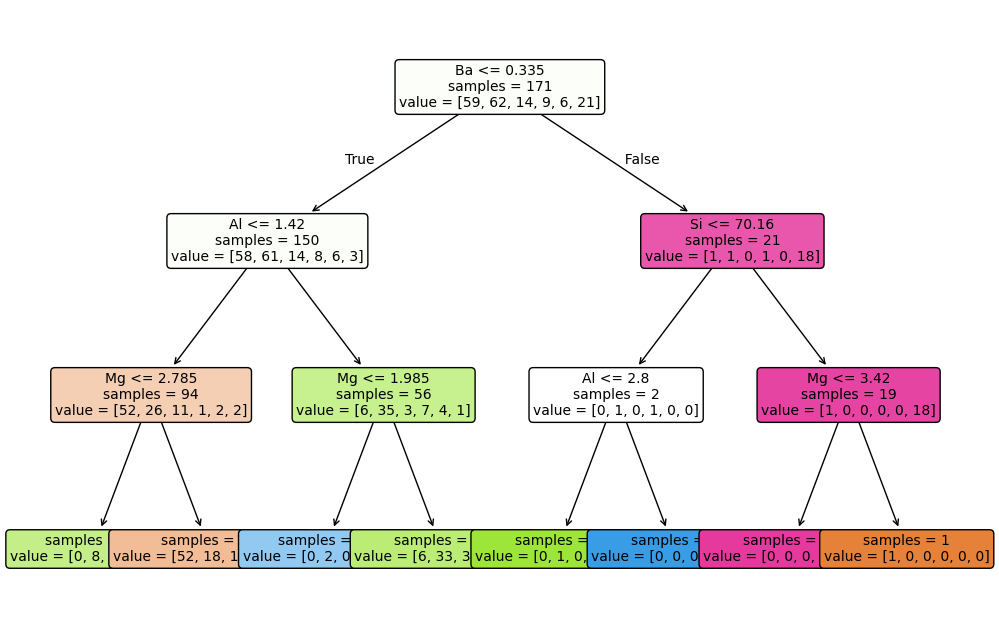

Accuracy: 0.7441860465116279

p1: Ba <= 0.335
p2: Al <= 1.42
p3: Mg <= 2.785
p4: Mg <= 1.985
p5: Si <= 70.16
p6: Al <= 2.8
p7: Mg <= 3.42

Fact: p1 | -p5 & p1 | -p7 & p2 | -p1 & -p1 | -p3
Foil: p1 | p5 & p1 | -p6 & p4 | -p1 & -p1 | -p2

Global contrast:



"\nindex = np.random.choice(np.where(y_pred == 0)[0])\ninstance = str()\ninstance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)\nfor j in range(len(instance_as_dict.keys())):\n    key = list(instance_as_dict.keys())[j]\n    if j > 0:\n        instance += ' & '\n    if instance_as_dict[key] == 0:\n        instance += f'-{key}'\n    else:\n        instance += f'{key}'\nprint(f'Instance: {instance}')\n_instance = __parse_cnf(instance)\nprint(f'Prediction: {y_pred[index]}')\nprint()\n\nprint(f'Counterfactual contrastive explanation:')\nencoding = ''.join(__cnf_to_facts(_instance,fact,foil))\nwith open(ENC['CF_CE'], 'r') as f:\n    encoding += f.read()\n__clingo_solve(encoding, max_clauses = 4)\nprint()\n\nprint(f'Counterfactual difference:')\nencoding = ''.join(__cnf_to_facts(_instance,fact,foil))\nwith open(ENC['CF_DIFF'], 'r') as f:\n    encoding += f.read()\n__clingo_solve(encoding, max_clauses = 5)\nprint()\n"

In [ ]:
dataset = openml.datasets.get_dataset(43750)
X,_, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
y = X['Type'].map({1: 0, 2: 1, 3: 2, 5:3, 6:4, 7:5})
X.drop(columns = ['Type'], inplace = True)

categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number", "float", "int"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep numerical columns
)

X_transformed = preprocessor.fit_transform(X)

encoded_feature_names = []
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat']
    encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + numerical_cols

X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X_transformed_df.columns, filled=True, rounded=True, fontsize=10, impurity=False, proportion=False)
plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_train.columns, 0, 3)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrast:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4, max_lits = 2)
print()

index = np.random.choice(np.where(y_pred == 0)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 5)
print()

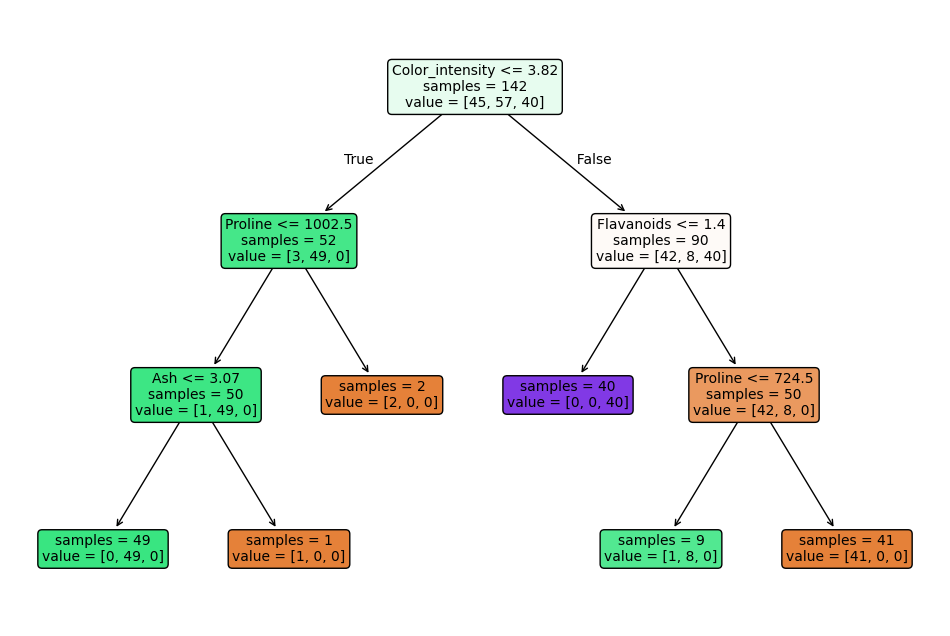

Accuracy: 0.9444444444444444

p1: Color_intensity <= 3.82
p2: Proline <= 1002.5
p3: Ash <= 3.07
p4: Flavanoids <= 1.4
p5: Proline <= 724.5

Fact: p3 | -p1 | -p2 & p2 | -p1 & p1 | -p4 & p1 | p4 | p5
Foil: -p1 | -p2 | -p3 & p3 | -p1 | -p2 & p2 | -p1 & p1 | p4 | -p5 & p1 | p4 | p5

Global contrast:
SOLUTION (cost [10, -4]):
Theta:
p1 | -p4  &  p1 | p5
Theta':
-p1  &  p4
Chi:
p3 | -p1  &  p2 | -p1


Instance: p1 & p2 & p3 & -p4 & p5
Prediction: 1

Counterfactual contrastive explanation:
SOLUTION (cost [5, -2]):
Theta:
p1
Theta':
p4  &  -p1
Chi:
p3  &  p2


Counterfactual difference:
SOLUTION (cost [7, -3]):
Theta:
p1  &  -p4
Theta':
p4  &  -p1
Chi:
p2  &  p5  &  p3




In [ ]:
dataset = openml.datasets.get_dataset(43571)
X, _, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
y = X['Wine'].map({1: 0, 2: 1, 3: 2})
X.drop(columns = ['Wine'], inplace = True)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number", "float", "int"]).columns.tolist()

# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep numerical columns
)

X_transformed = preprocessor.fit_transform(X)

encoded_feature_names = []
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat']
    encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(encoded_feature_names) + numerical_cols

X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X_transformed_df.columns, filled=True, rounded=True, fontsize=10, impurity=False, proportion=False)
plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_train.columns, 1, 2)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrast:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 3, max_lits = 3)
print()

index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

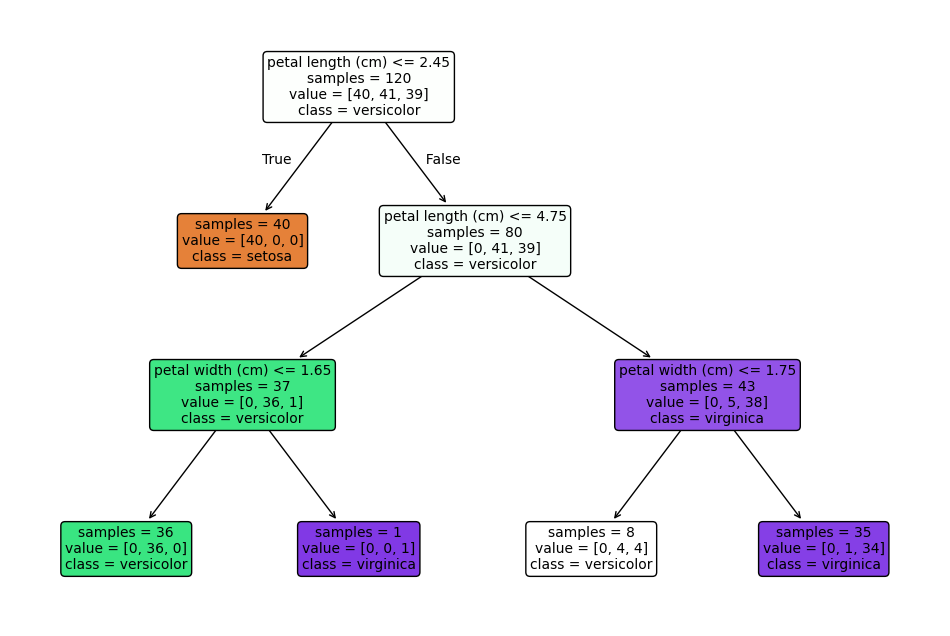

Accuracy: 1.0

p1: petallength(cm) <= 2.45
p2: petallength(cm) <= 4.75
p3: petalwidth(cm) <= 1.65
p4: petalwidth(cm) <= 1.75

Fact: -p1 & p1 | -p2 | p3 & p1 | p2 | p4
Foil: -p1 & p1 | -p2 | -p3 & p1 | p2 | -p4

Global contrast:
SOLUTION (cost [9, -1]):
Theta:
p3 | -p2  &  p2 | p4
Theta':
-p2 | -p3  &  p2 | -p4
Chi:
-p1


Instance: -p1 & p2 & p3 & p4
Prediction: 1

Counterfactual contrastive explanation:
SOLUTION (cost [4, -2]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  -p1


Counterfactual difference:
SOLUTION (cost [5, -3]):
Theta:
p3
Theta':
-p3
Chi:
p2  &  p4  &  -p1




In [ ]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.columns = df.columns.str.replace(' ', '')

df['target'] = iris.target
X = df.drop(columns = ['target'], axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, fontsize=10, impurity=False, proportion=False)
plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

output = tree_to_cnf(model, X_train.columns, 1, 2)
cnf1 = output['fact_cnf']
cnf2 = output['foil_cnf']
var_map = output['var_mapping']

for key, (feature, threshold) in var_map.items():
    print(f'{key}: {feature} <= {threshold}')
print()

fact = __parse_cnf(cnf1)
foil = __parse_cnf(cnf2)
print(f'Fact: {cnf1}')
print(f'Foil: {cnf2}')
print()

print(f'Global contrast:')
encoding = ''.join(__cnf_to_facts([],fact,foil))
with open(ENC['GLOBAL_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 3, max_lits = 3)
print()

# Compute explanations for positive predictions.
index = np.random.choice(np.where(y_pred == 1)[0])
instance = str()
instance_as_dict = evaluate_instance_against_vars(X_test.iloc[index].to_dict(), var_map)
for j in range(len(instance_as_dict.keys())):
    key = list(instance_as_dict.keys())[j]
    if j > 0:
        instance += ' & '
    if instance_as_dict[key] == 0:
        instance += f'-{key}'
    else:
        instance += f'{key}'
print(f'Instance: {instance}')
_instance = __parse_cnf(instance)
print(f'Prediction: {y_pred[index]}')
print()

print(f'Counterfactual contrastive explanation:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_CE'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()

print(f'Counterfactual difference:')
encoding = ''.join(__cnf_to_facts(_instance,fact,foil))
with open(ENC['CF_DIFF'], 'r') as f:
    encoding += f.read()
__clingo_solve(encoding, max_clauses = 4)
print()